In [1]:
import os
DATA_DIR = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
!ls $DATA_DIR
INPUT_SHAPE = (224, 224, 3)

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


In [2]:
import pandas as pd

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img


def read_trainset(filename=DATA_DIR+"stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [3]:
import keras
import cv2
from math import ceil
import numpy as np
import pydicom

np.random.seed(257)

def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    img = bsb_window(dcm)
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_dir, id_list, labels, batch_size, img_size):

        self.list_IDs = id_list
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))
            
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import ShuffleSplit 

train_df = read_trainset()

# k-fold splitting
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=257).split(train_df.index)
# get indeces for one split
train_idx, valid_idx = next(ss)
train_df_kfold = train_df.iloc[train_idx]
valid_df_kfold = train_df.iloc[valid_idx]

In [5]:
gen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                    id_list=train_df_kfold.index[:1000], #MAGIC, #BUG
                    labels=train_df_kfold[:1000], #MAGIC, #BUG
                    batch_size=32,
                    img_size=INPUT_SHAPE)

In [6]:
import keras
from keras.applications.vgg16 import VGG16
from keras import layers
import numpy as np

conv_base = VGG16(weights='imagenet', input_shape=INPUT_SHAPE ,include_top=False)

conv_base.trainable = False
model = keras.models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    #loss='categorical_crossentropy', # mutually exclusive
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=['accuracy']
    
)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 21,139,014
Trainable params: 6,424,326
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
hist = model.fit_generator(gen,
                    epochs=15,
                    verbose=True,
                    use_multiprocessing=True,
                    workers=4)

Epoch 1/15
12/12 [==============================] - 11s 882ms/step - loss: 0.6620 - accuracy: 0.8711
Epoch 2/15
13/13 [==============================] - 7s 527ms/step - loss: 0.4856 - accuracy: 0.8962
Epoch 3/15
12/12 [==============================] - 7s 544ms/step - loss: 0.2428 - accuracy: 0.9280
Epoch 3/15Epoch 4/15
13/13 [==============================] - 7s 519ms/step - loss: 0.2059 - accuracy: 0.9375
Epoch 5/15
13/13 [==============================] - 7s 504ms/step - loss: 0.1574 - accuracy: 0.9467
Epoch 6/15
12/12 [==============================] - 6s 492ms/step - loss: 0.1297 - accuracy: 0.9583
Epoch 7/15
12/12 [==============================] - 6s 509ms/step - loss: 0.1186 - accuracy: 0.9575
Epoch 8/15
12/12 [==============================] - 6s 517ms/step - loss: 0.1353 - accuracy: 0.9527
Epoch 9/15
12/12 [==============================] - 6s 522ms/step - loss: 0.0788 - accuracy: 0.9709
Epoch 10/15
12/12 [==============================] - 6s 488ms/step - loss: 0.1031 - accur

In [8]:
X,y = gen[0]

In [9]:
p = model.predict(X)

In [10]:
p > 0.5

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True, False,  True,  True, False, False],
       [ True, False,  True,  True, False, False],
       [ True, False,  True, False, False, False],
       [ True, False,  True,  True, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True, False, False,  True,  True,  True],
       [False, False, False, Fa

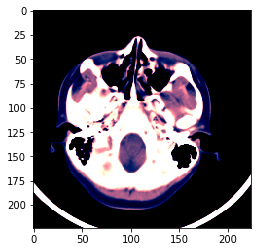

In [11]:
import matplotlib.pyplot as plt
plt.imshow(X[0])